## Illustration of missing features and value imputation for Hodgkin-Huxley model

In [1]:
import delfi.utils.io as io
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley

%matplotlib inline

In [2]:
true_params, _ = utils.obs_params()

seed = 1

I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed)

prior_log = False
p = utils.prior(true_params=true_params, prior_extent=False,prior_log=prior_log, seed=seed)

## plotting original data and samples with missing spikes

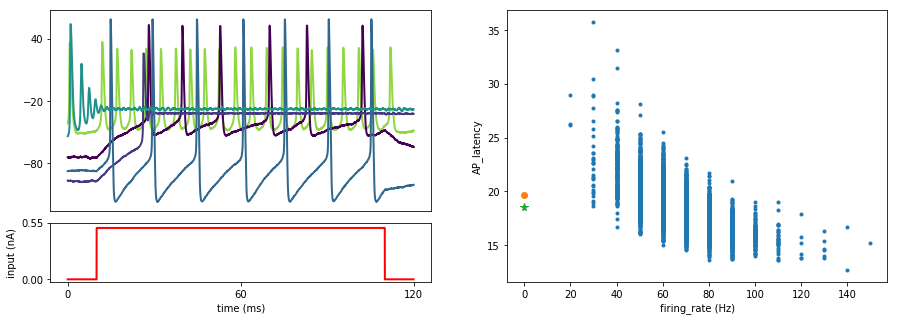

In [3]:
fig = plt.figure(figsize = (15,5))

t = obs['time']
duration = np.max(t)

A_soma = np.pi*((70.*1e-4)**2)  # cm2

num_samp = 5
num_colors = num_samp+1
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

ax = plt.subplot2grid((4, 2), (0, 0), rowspan=3)

# samples from prior
params = p.gen(n_samples=num_samp)

# simulation and plotting
V = np.zeros((len(t),num_samp))
for i in range(num_samp):
    m = HodgkinHuxley(I=I, dt=dt, seed=230+i, cython=True, prior_log=prior_log)
    x = m.gen_single(params[i,:])
    V[:,i] = x['data']
    plt.plot(t, V[:, i], color = col1[i-1], lw=2)

ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

# ax = plt.subplot(gs[2])
ax = plt.subplot2grid((4, 2), (3, 0))
plt.plot(t,I*A_soma*1e3,color = 'r', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))


########################
# results for inference where missing features have imputed values
out_mf = pickle.load(open('./results/mf/miss_feat_run_2_round5.pkl', 'rb'))
res_mf = io.load('./results/mf/miss_feat_run_2_round5_res.pkl')

imputation_values = out_mf[0][-1]['imputation_values'][-1]*res_mf.stats_std+res_mf.stats_mean

obs_stats_round = out_mf[1][-1][1]*res_mf.stats_std+res_mf.stats_mean

ax = plt.subplot2grid((4, 2), (0, 1), rowspan=4)
plt.plot(1e3*obs_stats_round[:,0],obs_stats_round[:,1],'.')
plt.plot(0,imputation_values[1],'o',markersize=6)
plt.plot(0,np.nanmean(obs_stats_round[:,1]),'*',markersize=8)

plt.xlabel('firing_rate (Hz)')
plt.ylabel('AP_latency');